In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import numpy as np
import jax.numpy as jnp

from utils import manifold, metrics
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

# Full phase space

In [2]:
def preprocess(data, scaler):
    scaled_data = scaler().fit_transform(data.reshape(-1, 2, 2).transpose(0,2,1).reshape(-1,2)).reshape(-1, 2, 2).transpose(0,2,1).reshape(data.shape)
    return scaled_data

file_name = "planar_orbits_400_200"
out_name = file_name
raw_data = np.load("data/" + file_name + ".npz")
raw_data, params = raw_data["data"], raw_data["params"]

H, L, phi0, e, a = params.T
data = preprocess(raw_data, MaxAbsScaler)

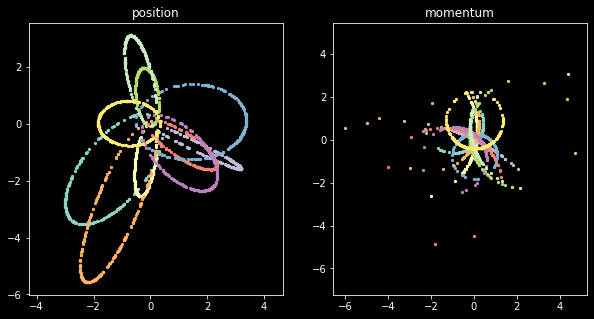

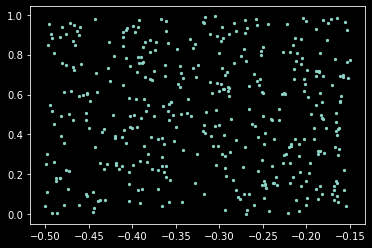

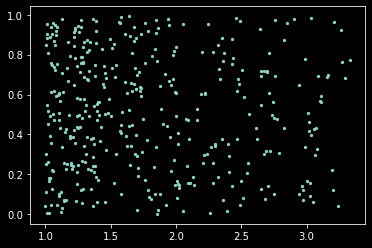

In [6]:
mu = 1
A = np.sqrt(mu**2+2*H*L**2)

plt.figure(figsize=(10, 5))
plt.subplot(121)
for traj in raw_data[:10]:
    plt.scatter(traj[:,0], traj[:,1], s=5.)
plt.axis('equal')
plt.title("position")

plt.subplot(122)
for traj in raw_data[:10]:
    plt.scatter(traj[:,2], traj[:,3], s=5.)
plt.axis('equal')
plt.title("momentum")

plt.figure()
plt.scatter(H, L, s=5)
plt.figure()
plt.scatter(a, L, s=5);

Converged? True
[]


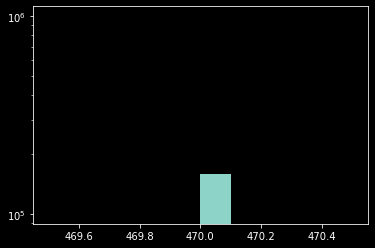

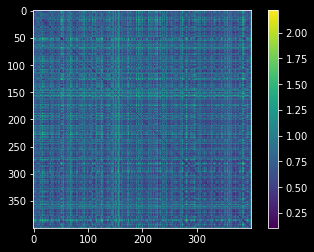

In [4]:
dist_mat, converged, steps = metrics.distance_matrix(data, mesh_shape=(4,2))

print("Converged?", jnp.all(converged))
print(np.stack(np.where(1-converged), axis=1))

plt.figure()
plt.hist([steps.reshape(-1)], log=True)
plt.figure()
plt.imshow(dist_mat)
plt.colorbar();

In [6]:
# np.savez(out_name + "_dist_mat.npz", dist_mat=dist_mat)
dist_mat = np.load(out_name + "_dist_mat.npz")['dist_mat']

In [7]:
evals, embedding, epsilon = manifold.diffusion_map(dist_mat, n_components=20, epsilon='max', n_neighbors=200, alpha=1, robust=True)

nn_max = 1.2760268449783325
epsilon = 3.256489018210715
mean_shift = 0.0031546098


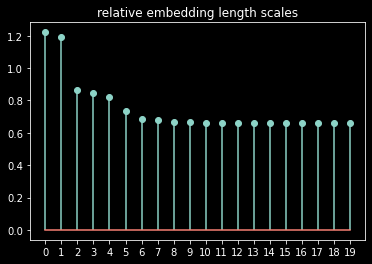

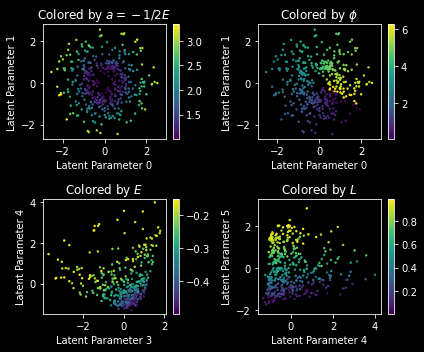

In [8]:
plt.figure()
# plt.stem(1/np.sqrt(-evals), use_line_collection=True)
plt.stem(np.sqrt(-epsilon/np.log(1+evals)), use_line_collection=True)
plt.title('relative embedding length scales')
plt.xticks(ticks=range(evals.shape[0]))

plt.figure(figsize=(6,5))
plt.subplot(221)
plt.scatter(embedding[:,0], embedding[:,1], c=a, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 0")
plt.ylabel("Latent Parameter 1")
plt.title("Colored by $a=-1/2E$")
plt.axis('equal')

plt.subplot(222)
plt.scatter(embedding[:,0], embedding[:,1], c=phi0, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 0")
plt.ylabel("Latent Parameter 1")
plt.title("Colored by $\phi$")
plt.axis('equal')

plt.subplot(223)
plt.scatter(embedding[:,3], embedding[:,4], c=H, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 3")
plt.ylabel("Latent Parameter 4")
plt.title("Colored by $E$")
plt.axis('equal')

plt.subplot(224)
plt.scatter(embedding[:,4], embedding[:,5], c=L, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 4")
plt.ylabel("Latent Parameter 5")
plt.title("Colored by $L$")
plt.axis('equal')
plt.tight_layout()

[0, 1, 5]


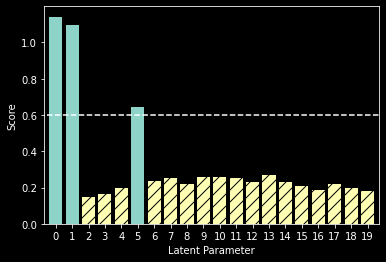

In [15]:
threshold = 0.6
n_components = evals.shape[0]

embed_list, scores_pass, scores_fail = manifold.heuristic_importance_score(evals, embedding, threshold=threshold, weights="adjusted")
print(embed_list)

plt.bar(list(range(n_components)), scores_pass[:n_components])
plt.bar(list(range(n_components)), scores_fail[:n_components], hatch='//')
plt.xticks(ticks=range(n_components))
plt.xlim(-0.7, n_components-0.3)
# plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Latent Parameter")
plt.hlines(threshold, -1, n_components, 'white', linestyles='dashed');
# plt.savefig("unpredictability_scores.png", dpi=300)

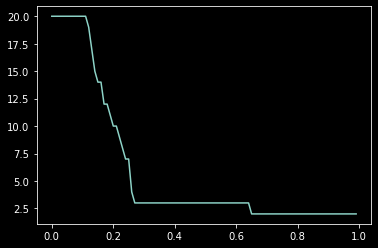

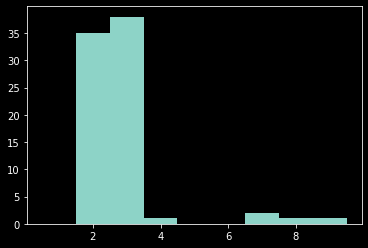

In [40]:
embedding_size_list = []
for thres in np.arange(0.0, 1., 0.01):
    embedding_size_list.append(len(manifold.heuristic_importance_score(evals, embedding, threshold=thres, weights="adjusted")[0]))

plt.figure()
plt.plot(np.arange(0.0, 1., 0.01), embedding_size_list)
plt.figure()
plt.hist(embedding_size_list, bins=np.arange(10)+0.5);

planar_orbits_400_200


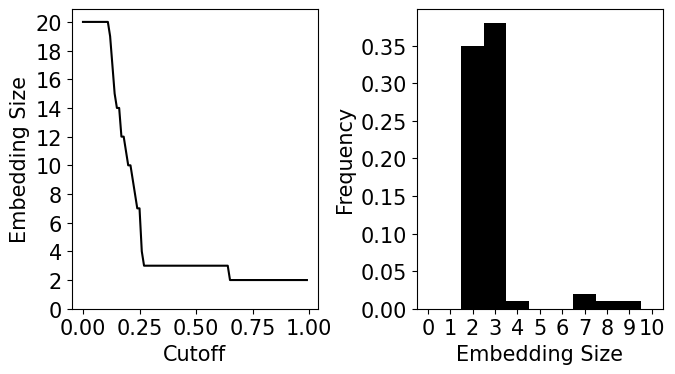

In [75]:
print(out_name)
with plt.style.context("default"):
    plt.rcParams.update({'font.size': 15})
    
    plt.figure(figsize=(7,4))
    plt.subplot(121)
    plt.plot(np.arange(0.0, 1., 0.01), embedding_size_list, 'k')
    # plt.ylim(0,20)
    plt.yticks(np.arange(0,21,2))
    plt.xlabel("Cutoff")
    plt.ylabel("Embedding Size")

    plt.subplot(122)
    plt.hist(embedding_size_list, bins=np.arange(10)+0.5, color='k', weights=np.ones_like(embedding_size_list) / len(embedding_size_list))
    plt.xticks(np.arange(21))
    plt.xlim(-0.5, 10.5)
    plt.xlabel("Embedding Size")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_cutoff.pdf", bbox_inches="tight")
    

0.9871028715314466
SpearmanrResult(correlation=0.9940052125325782, pvalue=0.0)


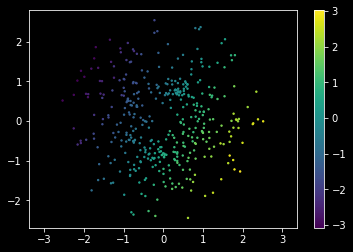

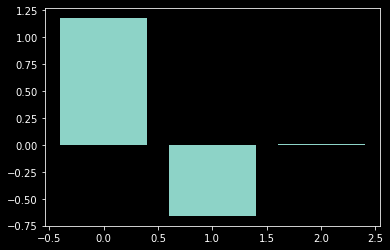

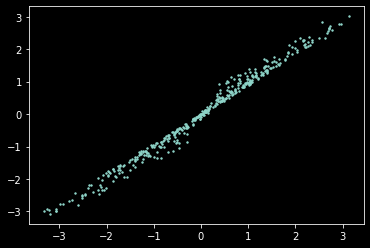

In [21]:
from sklearn.linear_model import LinearRegression
X = embedding[:, embed_list]
y = a*np.cos(phi0)

plt.scatter(embedding[:,0], embedding[:,1], c=y, s=2)
plt.colorbar()
plt.axis('equal');

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))

from scipy.stats import spearmanr
print(spearmanr(reg.predict(X), y))

plt.figure()
plt.bar(range(reg.coef_.shape[0]), reg.coef_)
plt.figure()
plt.scatter(reg.predict(X), y, s=2);

0.986015340053508
SpearmanrResult(correlation=0.9924868280426753, pvalue=0.0)


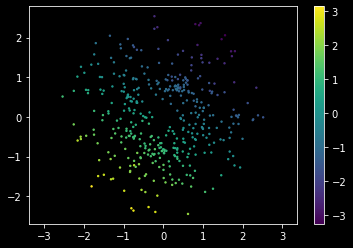

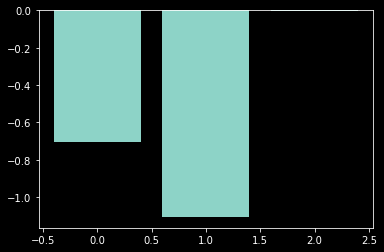

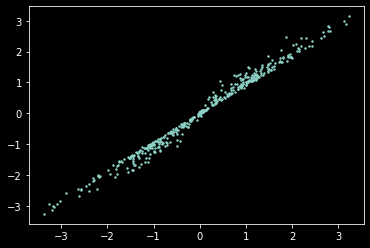

In [23]:
from sklearn.linear_model import LinearRegression
X = embedding[:, embed_list]
y = a*np.sin(phi0)

plt.scatter(embedding[:,0], embedding[:,1], c=y, s=2)
plt.colorbar()
plt.axis('equal');

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))

from scipy.stats import spearmanr
print(spearmanr(reg.predict(X), y))

plt.figure()
plt.bar(range(reg.coef_.shape[0]), reg.coef_)
plt.figure()
plt.scatter(reg.predict(X), y, s=2);

0.9268539333377395
SpearmanrResult(correlation=0.9700896255601597, pvalue=8.055729184364044e-247)


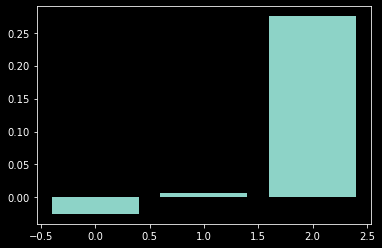

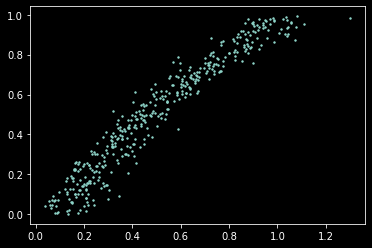

In [22]:
from sklearn.linear_model import LinearRegression
X = embedding[:, embed_list]
y = L

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))

from scipy.stats import spearmanr
print(spearmanr(reg.predict(X), y))

plt.figure()
plt.bar(range(reg.coef_.shape[0]), reg.coef_)
plt.figure()
plt.scatter(reg.predict(X), y, s=2);

In [16]:
# print(out_name)
# with plt.style.context("default"):
#     plt.rcParams.update({'font.size': 15})
#     plt.figure(figsize=(6, 3))
#     plt.subplot(121)
#     for traj in raw_data[:20]:
#         plt.scatter(traj[:,0], traj[:,1], s=2)
#     plt.axis('equal')
#     plt.title("Position $\mathbf{r}$")

#     plt.subplot(122)
#     for traj in raw_data[:20]:
#         plt.scatter(traj[:,2], traj[:,3], s=2)
#     plt.axis('equal')
#     plt.title("Momentum $\mathbf{p}$")
#     plt.tight_layout()
#     plt.savefig(f"figures/{out_name}_data.pdf", bbox_inches="tight")

#     plt.figure(figsize=(7,6))
#     plt.subplot(221)
#     plt.scatter(embedding[:,0], embedding[:,1], c=a, s=2)
#     plt.colorbar()
#     plt.xlabel("Component 1")
#     plt.ylabel("Component 2")
#     plt.title("Colored by $a=-1/2E$")
#     plt.axis('equal')

#     plt.subplot(222)
#     plt.scatter(embedding[:,0], embedding[:,1], c=phi0, s=2, cmap='twilight', vmin=0, vmax=2*np.pi)
#     cbar = plt.colorbar(ticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
#     cbar.ax.set_yticklabels(['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']) 
#     plt.xlabel("Component 1")
#     plt.ylabel("Component 2")
#     plt.title("Colored by $\phi$")
#     plt.axis('equal')

#     plt.subplot(223)
#     plt.scatter(embedding[:,3], embedding[:,4], c=H, s=2)
#     plt.colorbar()
#     plt.xlabel("Component 4")
#     plt.ylabel("Component 5")
#     plt.title("Colored by $E$")
#     plt.axis('equal')

#     plt.subplot(224)
#     plt.scatter(embedding[:,4], embedding[:,5], c=L, s=2)
#     plt.colorbar()
#     plt.xlabel("Component 5")
#     plt.ylabel("Component 6")
#     plt.title("Colored by $L$")
#     plt.axis('equal')

#     plt.tight_layout()
#     plt.savefig(f"figures/{out_name}_embedding.pdf", bbox_inches="tight")

#     plt.figure(figsize=(3, 3))
#     plt.imshow(dist_mat)
#     plt.xlabel("Trajectory Index")
#     plt.ylabel("Trajectory Index")
#     plt.tight_layout()

#     plt.savefig(f"figures/{out_name}_dist_mat.pdf", bbox_inches="tight")

#     plt.figure(figsize=(3, 3))
#     n_show_components = 10
#     plt.bar(
#         list(range(1, n_components+1)[:n_show_components]),
#         scores_pass[:n_show_components],
#         color="k",
#     )
#     plt.bar(
#         list(range(1, n_components+1)[:n_show_components]),
#         scores_fail[:n_show_components],
#         hatch="//",
#         color="gray",
#     )
#     plt.xticks(ticks=range(1, n_components+1)[:n_show_components])
#     plt.xlim(0.3, n_show_components + 0.7)
#     # plt.ylim(0, 1)
#     plt.ylabel("Score")
#     plt.xlabel("Component")
#     plt.hlines(threshold, 0, n_show_components+1, "gray", linestyles="dashed")
#     plt.savefig(f"figures/{out_name}_score.pdf", bbox_inches="tight")


planar_orbits_400_200


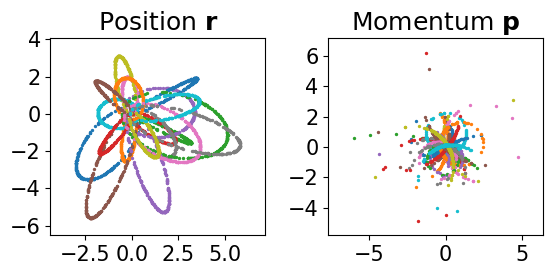

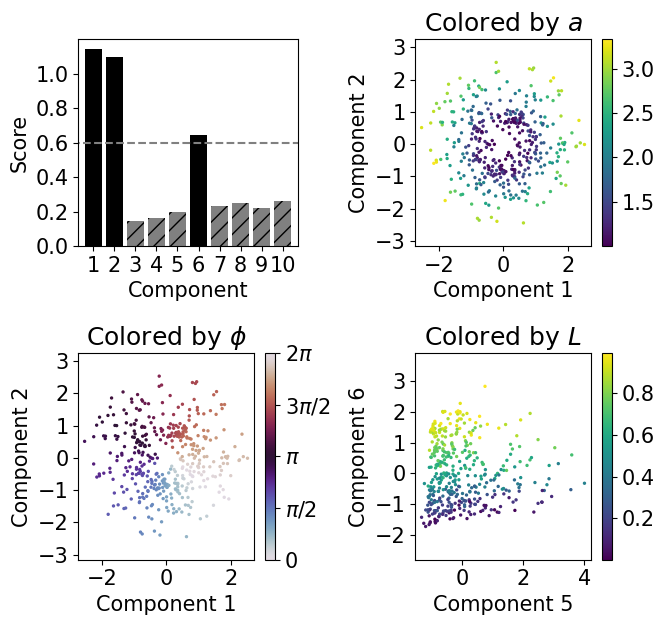

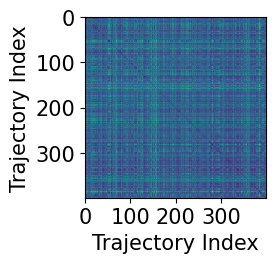

In [19]:
print(out_name)
with plt.style.context("default"):
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(6, 3))
    plt.subplot(121)
    for traj in raw_data[:20]:
        plt.scatter(traj[:,0], traj[:,1], s=2)
    plt.axis('equal')
    plt.title("Position $\mathbf{r}$")

    plt.subplot(122)
    for traj in raw_data[:20]:
        plt.scatter(traj[:,2], traj[:,3], s=2)
    plt.axis('equal')
    plt.title("Momentum $\mathbf{p}$")
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_data.pdf", bbox_inches="tight")

    plt.figure(figsize=(7,6.5))

    plt.subplot(221)
    n_show_components = 10
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_pass[:n_show_components],
        color="k",
    )
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_fail[:n_show_components],
        hatch="//",
        color="gray",
    )
    plt.xticks(ticks=range(1, n_components+1)[:n_show_components])
    plt.xlim(0.3, n_show_components + 0.7)
    # plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xlabel("Component")
    plt.hlines(threshold, 0, n_show_components+1, "gray", linestyles="dashed")

    plt.subplot(222)
    plt.scatter(embedding[:,0], embedding[:,1], c=a, s=2)
    plt.colorbar()
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title("Colored by $a$")
    plt.axis('equal')

    plt.subplot(223)
    plt.scatter(embedding[:,0], embedding[:,1], c=phi0, s=2, cmap='twilight', vmin=0, vmax=2*np.pi)
    cbar = plt.colorbar(ticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    cbar.ax.set_yticklabels(['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']) 
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title("Colored by $\phi$")
    plt.axis('equal')

    # plt.subplot(223)
    # plt.scatter(embedding[:,3], embedding[:,4], c=H, s=2)
    # plt.colorbar()
    # plt.xlabel("Component 4")
    # plt.ylabel("Component 5")
    # plt.title("Colored by $E$")
    # plt.axis('equal')

    plt.subplot(224)
    plt.scatter(embedding[:,4], embedding[:,5], c=L, s=2)
    plt.colorbar()
    plt.xlabel("Component 5")
    plt.ylabel("Component 6")
    plt.title("Colored by $L$")
    plt.axis('equal')

    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_embedding.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    plt.imshow(dist_mat)
    plt.xlabel("Trajectory Index")
    plt.ylabel("Trajectory Index")
    plt.tight_layout()

    plt.savefig(f"figures/{out_name}_dist_mat.pdf", bbox_inches="tight")


## Extra Score Figures

[0, 1, 5]


<BarContainer object of 20 artists>

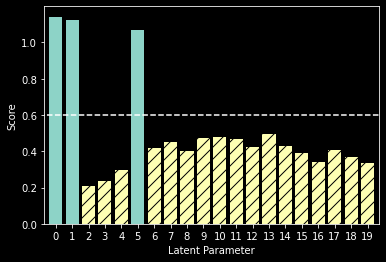

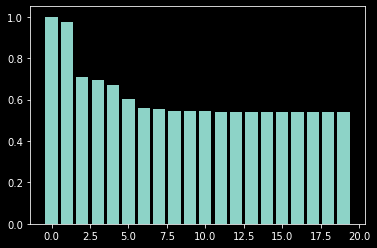

In [31]:
threshold = 0.6
n_components = evals.shape[0]

embed_constant_list, scores_constant_pass, scores_constant_fail = manifold.heuristic_importance_score(evals, embedding, threshold=threshold, weights="constant")
print(embed_list)

plt.bar(list(range(n_components)), scores_constant_pass[:n_components])
plt.bar(list(range(n_components)), scores_constant_fail[:n_components], hatch='//')
plt.xticks(ticks=range(n_components))
plt.xlim(-0.7, n_components-0.3)
# plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Latent Parameter")
plt.hlines(threshold, -1, n_components, 'white', linestyles='dashed');
# plt.savefig("unpredictability_scores.png", dpi=300)

relevant_idx = evals > -1
weights = np.empty_like(evals)
weights[~relevant_idx] = 0
weights[relevant_idx] = np.sqrt(
    np.log(1 + evals[0]) / np.log(1 + evals[relevant_idx])
)

plt.figure()
plt.bar(list(range(n_components)), weights[:n_components])

planar_orbits_400_200


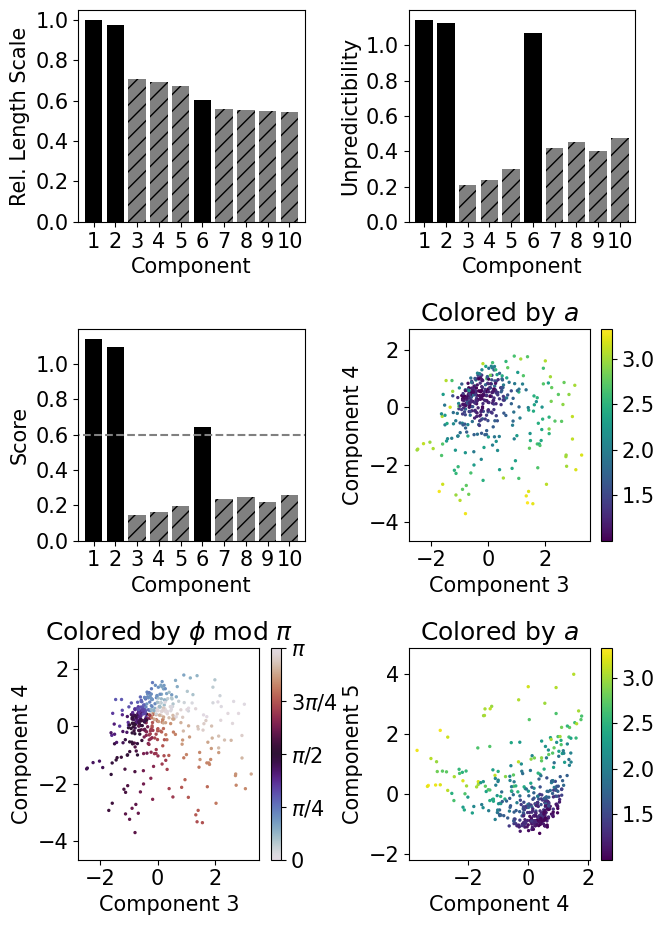

In [39]:
print(out_name)
with plt.style.context("default"):
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(7,9.5))

    plt.subplot(321)
    n_show_components = 10
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        ((np.array(scores_pass) > 0) * weights)[:n_show_components],
        color="k",
    )
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        ((np.array(scores_fail) > 0) * weights)[:n_show_components],
        hatch="//",
        color="gray",
    )
    plt.xticks(ticks=range(1, n_components+1)[:n_show_components])
    plt.xlim(0.3, n_show_components + 0.7)
    # plt.ylim(0, 1)
    plt.ylabel("Rel. Length Scale")
    plt.xlabel("Component")

    plt.subplot(322)
    n_show_components = 10
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_constant_pass[:n_show_components],
        color="k",
    )
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_constant_fail[:n_show_components],
        hatch="//",
        color="gray",
    )
    plt.xticks(ticks=range(1, n_components+1)[:n_show_components])
    plt.xlim(0.3, n_show_components + 0.7)
    # plt.ylim(0, 1)
    plt.ylabel("Unpredictibility")
    plt.xlabel("Component")

    plt.subplot(323)
    n_show_components = 10
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_pass[:n_show_components],
        color="k",
    )
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_fail[:n_show_components],
        hatch="//",
        color="gray",
    )
    plt.xticks(ticks=range(1, n_components+1)[:n_show_components])
    plt.xlim(0.3, n_show_components + 0.7)
    # plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xlabel("Component")
    plt.hlines(threshold, 0, n_show_components+1, "gray", linestyles="dashed")

    plt.subplot(324)
    plt.scatter(embedding[:,2], embedding[:,3], c=a, s=2)
    plt.colorbar()
    plt.xlabel("Component 3")
    plt.ylabel("Component 4")
    plt.title("Colored by $a$")
    plt.axis('equal')

    plt.subplot(325)
    plt.scatter(embedding[:,2], embedding[:,3], c=np.mod(phi0, np.pi), s=2, cmap='twilight', vmin=0, vmax=np.pi)
    cbar = plt.colorbar(ticks=[0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
    cbar.ax.set_yticklabels(['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$']) 
    plt.xlabel("Component 3")
    plt.ylabel("Component 4")
    plt.title("Colored by $\phi$ mod $\pi$")
    plt.axis('equal')

    plt.subplot(326)
    plt.scatter(embedding[:,3], embedding[:,4], c=a, s=2)
    plt.colorbar()
    plt.xlabel("Component 4")
    plt.ylabel("Component 5")
    plt.title("Colored by $a$")
    plt.axis('equal')

    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_redundant_embedding.pdf", bbox_inches="tight")

# Position only

In [7]:
def preprocess(data, scaler):
    scaled_data = scaler().fit_transform(data.reshape(-1, 2, 2).transpose(0,2,1).reshape(-1,2)).reshape(-1, 2, 2).transpose(0,2,1).reshape(data.shape)
    return scaled_data[..., [0,1]]

file_name = "planar_orbits_400_200"
out_name = file_name + "_pos_only"
raw_data = np.load("data/" + file_name + ".npz")
raw_data, params = raw_data["data"], raw_data["params"]

H, L, phi0, e, a = params.T
data = preprocess(raw_data, MaxAbsScaler)

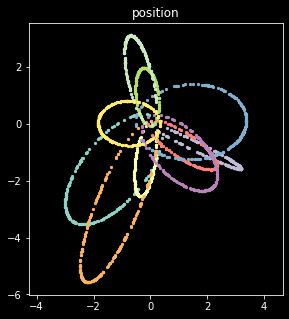

In [12]:
mu = 1
A = np.sqrt(mu**2+2*H*L**2)

plt.figure(figsize=(10, 5))
plt.subplot(121)
for traj in raw_data[:10]:
    plt.scatter(traj[:,0], traj[:,1], s=5.)
plt.axis('equal')
plt.title("position");

Converged? True
[]


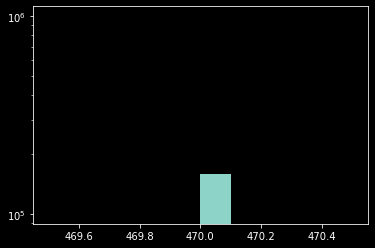

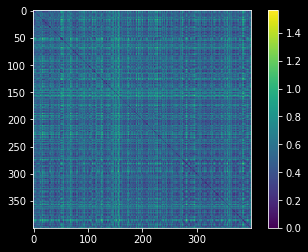

In [13]:
dist_mat, converged, steps = metrics.distance_matrix(data, mesh_shape=(4,2))

print("Converged?", jnp.all(converged))
print(np.stack(np.where(1-converged), axis=1))

plt.figure()
plt.hist([steps.reshape(-1)], log=True)
plt.figure()
plt.imshow(dist_mat)
plt.colorbar();

In [14]:
# np.savez(out_name + "_dist_mat.npz", dist_mat=dist_mat)
dist_mat = np.load(out_name + "_dist_mat.npz")['dist_mat']

In [27]:
evals, embedding, epsilon = manifold.diffusion_map(dist_mat, n_components=20, epsilon='max', n_neighbors=200, alpha=1, robust=True)

nn_max = 0.8929623961448669
epsilon = 1.5947636818575646
mean_shift = 0.003156155


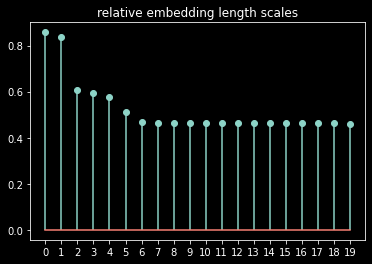

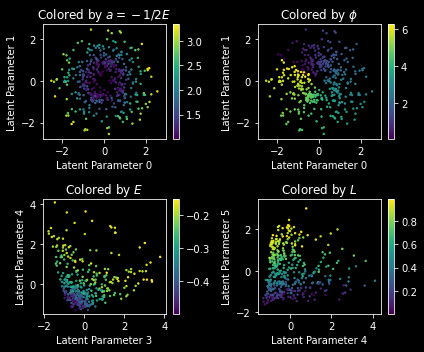

In [28]:
plt.figure()
# plt.stem(1/np.sqrt(-evals), use_line_collection=True)
plt.stem(np.sqrt(-epsilon/np.log(1+evals)), use_line_collection=True)
plt.title('relative embedding length scales')
plt.xticks(ticks=range(evals.shape[0]))

plt.figure(figsize=(6,5))
plt.subplot(221)
plt.scatter(embedding[:,0], embedding[:,1], c=a, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 0")
plt.ylabel("Latent Parameter 1")
plt.title("Colored by $a=-1/2E$")
plt.axis('equal')

plt.subplot(222)
plt.scatter(embedding[:,0], embedding[:,1], c=phi0, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 0")
plt.ylabel("Latent Parameter 1")
plt.title("Colored by $\phi$")
plt.axis('equal')

plt.subplot(223)
plt.scatter(embedding[:,3], embedding[:,4], c=H, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 3")
plt.ylabel("Latent Parameter 4")
plt.title("Colored by $E$")
plt.axis('equal')

plt.subplot(224)
plt.scatter(embedding[:,4], embedding[:,5], c=L, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 4")
plt.ylabel("Latent Parameter 5")
plt.title("Colored by $L$")
plt.axis('equal')
plt.tight_layout()

[0, 1, 5]


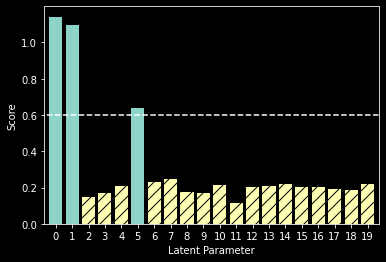

In [30]:
threshold = 0.6
n_components = evals.shape[0]

embed_list, scores_pass, scores_fail = manifold.heuristic_importance_score(evals, embedding, threshold=threshold, weights="adjusted")
print(embed_list)

plt.bar(list(range(n_components)), scores_pass[:n_components])
plt.bar(list(range(n_components)), scores_fail[:n_components], hatch='//')
plt.xticks(ticks=range(n_components))
plt.xlim(-0.7, n_components-0.3)
# plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Latent Parameter")
plt.hlines(threshold, -1, n_components, 'white', linestyles='dashed');
# plt.savefig("unpredictability_scores.png", dpi=300)

0.9867476433312095
SpearmanrResult(correlation=0.9939480246751542, pvalue=0.0)
0.9856519514247674
SpearmanrResult(correlation=0.9925033281458008, pvalue=0.0)
0.9100907776397762
SpearmanrResult(correlation=0.9675032343952148, pvalue=9.148758322554351e-240)


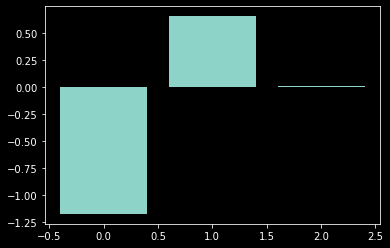

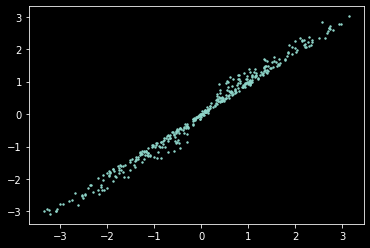

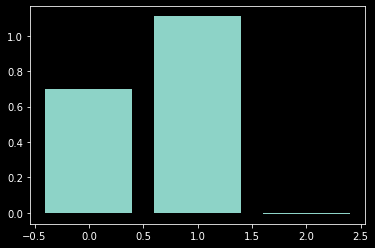

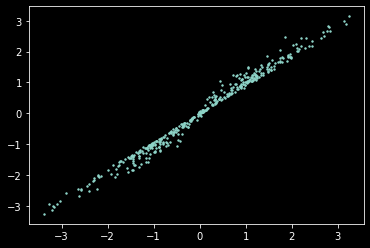

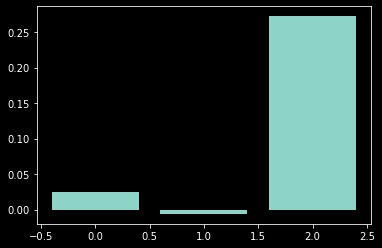

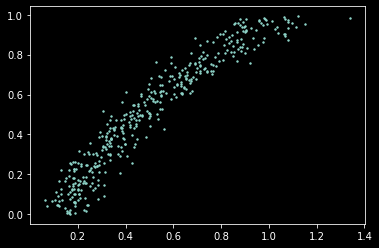

In [33]:
from sklearn.linear_model import LinearRegression
X = embedding[:, embed_list]

for y in [a*np.cos(phi0), a*np.sin(phi0), L]:
    reg = LinearRegression().fit(X, y)
    print(reg.score(X, y))

    from scipy.stats import spearmanr
    print(spearmanr(reg.predict(X), y))

    plt.figure()
    plt.bar(range(reg.coef_.shape[0]), reg.coef_)
    plt.figure()
    plt.scatter(reg.predict(X), y, s=2);

planar_orbits_400_200_pos_only


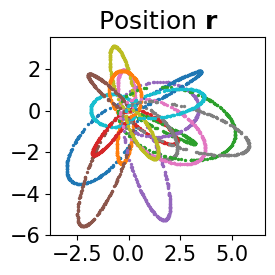

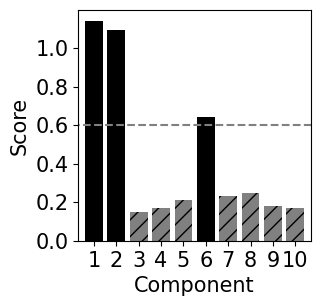

In [34]:
print(out_name)
with plt.style.context("default"):
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(3, 3))
    for traj in raw_data[:20]:
        plt.scatter(traj[:,0], traj[:,1], s=2)
    plt.axis('equal')
    plt.title("Position $\mathbf{r}$")
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_data.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    n_show_components = 10
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_pass[:n_show_components],
        color="k",
    )
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_fail[:n_show_components],
        hatch="//",
        color="gray",
    )
    plt.xticks(ticks=range(1, n_components+1)[:n_show_components])
    plt.xlim(0.3, n_show_components + 0.7)
    # plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xlabel("Component")
    plt.hlines(threshold, 0, n_show_components+1, "gray", linestyles="dashed")
    plt.savefig(f"figures/{out_name}_score.pdf", bbox_inches="tight")


# Noise

In [42]:
def preprocess(data, scaler, noise=0.0, rng=np.random.default_rng(0)):
    data += rng.normal(scale=noise, size=data.shape)
    scaled_data = scaler().fit_transform(data.reshape(-1, 2, 2).transpose(0,2,1).reshape(-1,2)).reshape(-1, 2, 2).transpose(0,2,1).reshape(data.shape)
    return scaled_data

noise = 0.5
file_name = "planar_orbits_400_200"
out_name = file_name + f"_noise{noise}"
raw_data = np.load("data/" + file_name + ".npz")
raw_data, params = raw_data["data"], raw_data["params"]

H, L, phi0, e, a = params.T
data = preprocess(raw_data, MaxAbsScaler, noise=noise)

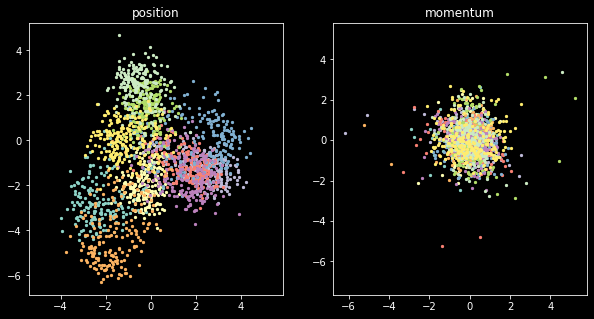

In [44]:
mu = 1
A = np.sqrt(mu**2+2*H*L**2)

plt.figure(figsize=(10, 5))
plt.subplot(121)
for traj in raw_data[:10]:
    plt.scatter(traj[:,0], traj[:,1], s=5.)
plt.axis('equal')
plt.title("position")

plt.subplot(122)
for traj in raw_data[:10]:
    plt.scatter(traj[:,2], traj[:,3], s=5.)
plt.axis('equal')
plt.title("momentum");

Converged? True
[]


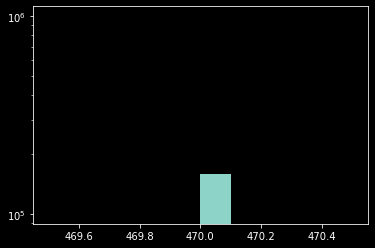

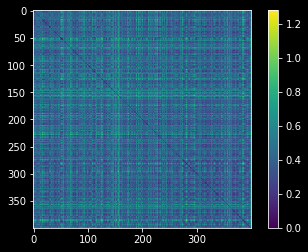

In [45]:
dist_mat, converged, steps = metrics.distance_matrix(data, mesh_shape=(4,2))

print("Converged?", jnp.all(converged))
print(np.stack(np.where(1-converged), axis=1))

plt.figure()
plt.hist([steps.reshape(-1)], log=True)
plt.figure()
plt.imshow(dist_mat)
plt.colorbar();

In [46]:
# np.savez(out_name + "_dist_mat.npz", dist_mat=dist_mat)
dist_mat = np.load(out_name + "_dist_mat.npz")['dist_mat']

In [47]:
evals, embedding, epsilon = manifold.diffusion_map(dist_mat, n_components=20, epsilon='max', n_neighbors=200, alpha=1, robust=True)

nn_max = 0.7231906056404114
epsilon = 1.04600930417309
mean_shift = 0.0031768186


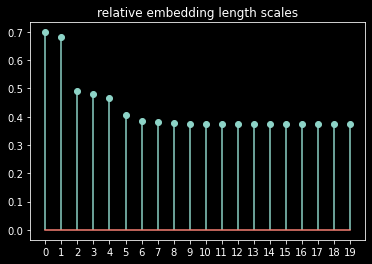

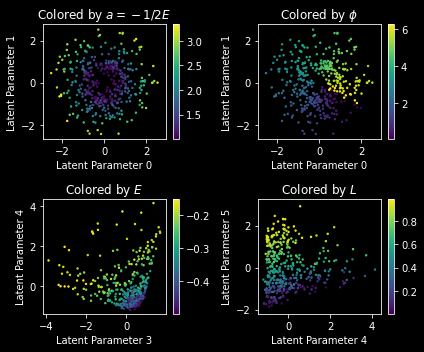

In [48]:
plt.figure()
# plt.stem(1/np.sqrt(-evals), use_line_collection=True)
plt.stem(np.sqrt(-epsilon/np.log(1+evals)), use_line_collection=True)
plt.title('relative embedding length scales')
plt.xticks(ticks=range(evals.shape[0]))

plt.figure(figsize=(6,5))
plt.subplot(221)
plt.scatter(embedding[:,0], embedding[:,1], c=a, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 0")
plt.ylabel("Latent Parameter 1")
plt.title("Colored by $a=-1/2E$")
plt.axis('equal')

plt.subplot(222)
plt.scatter(embedding[:,0], embedding[:,1], c=phi0, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 0")
plt.ylabel("Latent Parameter 1")
plt.title("Colored by $\phi$")
plt.axis('equal')

plt.subplot(223)
plt.scatter(embedding[:,3], embedding[:,4], c=H, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 3")
plt.ylabel("Latent Parameter 4")
plt.title("Colored by $E$")
plt.axis('equal')

plt.subplot(224)
plt.scatter(embedding[:,4], embedding[:,5], c=L, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 4")
plt.ylabel("Latent Parameter 5")
plt.title("Colored by $L$")
plt.axis('equal')
plt.tight_layout()

[0, 1, 5]


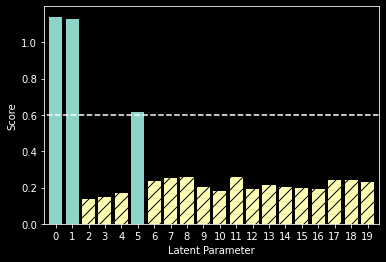

In [49]:
threshold = 0.6
n_components = evals.shape[0]

embed_list, scores_pass, scores_fail = manifold.heuristic_importance_score(evals, embedding, threshold=threshold, weights="adjusted")
print(embed_list)

plt.bar(list(range(n_components)), scores_pass[:n_components])
plt.bar(list(range(n_components)), scores_fail[:n_components], hatch='//')
plt.xticks(ticks=range(n_components))
plt.xlim(-0.7, n_components-0.3)
# plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Latent Parameter")
plt.hlines(threshold, -1, n_components, 'white', linestyles='dashed');
# plt.savefig("unpredictability_scores.png", dpi=300)

0.9864156277160175
SpearmanrResult(correlation=0.993723585772411, pvalue=0.0)
0.9852997656293706
SpearmanrResult(correlation=0.9923542647141543, pvalue=0.0)
0.8799488077997195
SpearmanrResult(correlation=0.9448028425177658, pvalue=5.674407675447035e-195)


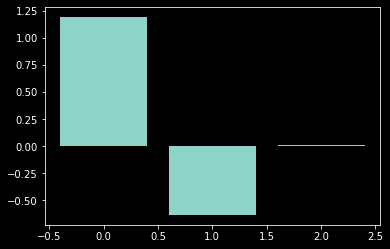

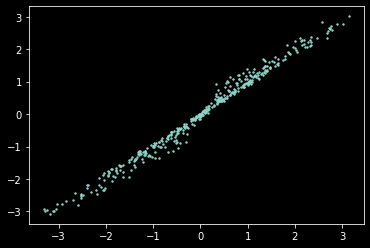

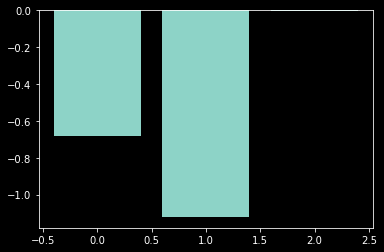

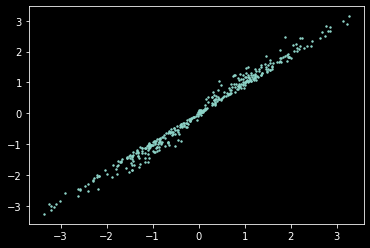

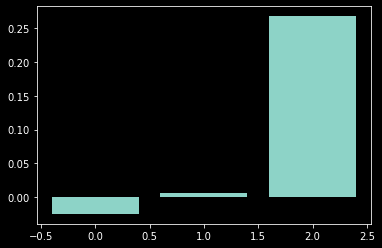

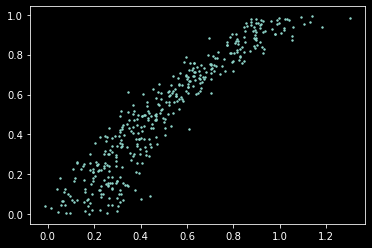

In [50]:
from sklearn.linear_model import LinearRegression
X = embedding[:, embed_list]

for y in [a*np.cos(phi0), a*np.sin(phi0), L]:
    reg = LinearRegression().fit(X, y)
    print(reg.score(X, y))

    from scipy.stats import spearmanr
    print(spearmanr(reg.predict(X), y))

    plt.figure()
    plt.bar(range(reg.coef_.shape[0]), reg.coef_)
    plt.figure()
    plt.scatter(reg.predict(X), y, s=2);

planar_orbits_400_200_noise0.5


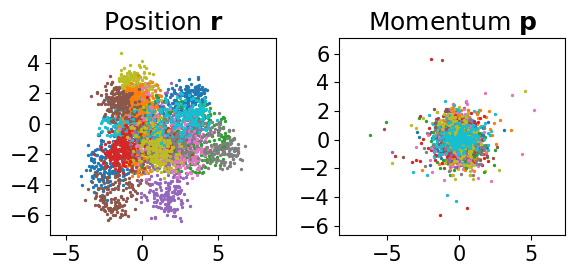

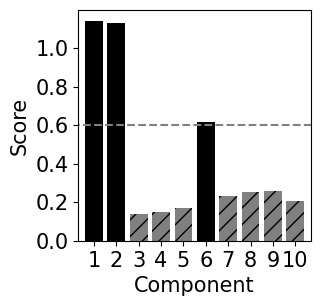

In [51]:
print(out_name)
with plt.style.context("default"):
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(6, 3))
    plt.subplot(121)
    for traj in raw_data[:20]:
        plt.scatter(traj[:,0], traj[:,1], s=2)
    plt.axis('equal')
    plt.title("Position $\mathbf{r}$")

    plt.subplot(122)
    for traj in raw_data[:20]:
        plt.scatter(traj[:,2], traj[:,3], s=2)
    plt.axis('equal')
    plt.title("Momentum $\mathbf{p}$")
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_data.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    n_show_components = 10
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_pass[:n_show_components],
        color="k",
    )
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_fail[:n_show_components],
        hatch="//",
        color="gray",
    )
    plt.xticks(ticks=range(1, n_components+1)[:n_show_components])
    plt.xlim(0.3, n_show_components + 0.7)
    # plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xlabel("Component")
    plt.hlines(threshold, 0, n_show_components+1, "gray", linestyles="dashed")
    plt.savefig(f"figures/{out_name}_score.pdf", bbox_inches="tight")
